In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GCNConv

from get_data import collect_data_from_matches

from model_building import build_graph_from_frame, TemporalRunnerDataset, TemporalRunnerGNN, train_model, collate_fn, predict_optimal_run

from visualization_tools import plot_soccer_pitch
from visualization_tools import animate_run
from visualization_tools import plot_spatial_graph
from visualization_tools import plot_optimal_run

# Load Data

In [2]:
matches = [1886347]
possessions, run_features,tracking_data,player_to_team,merged = collect_data_from_matches(matches)


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\zcoch\sports_cup_research\skill_corner_analytics_cup_tracking_data_research\get_data.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_tracking[col] = -run_tracking[col]
c:\Users\zcoch\sports_cup_research\skill_corner_analytics_cup_tracking_data_research\get_data.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_tracking["match_id"] = match_id
c:\Users\zcoch\sports_cup_research\skill_corner_analytics_cup_tracking_data_research\get_data.py:196: Se

In [50]:
# match_info = pd.read_csv("data/matches_info.csv")
# possessions = pd.read_csv("data/possessions.csv")
# run_features = pd.read_csv("data/run_features.csv")
# tracking_data = pd.read_csv("data/tracking_data.csv")
# player_to_team = pd.read_csv("data/player_team.csv").set_index("id")

# merged = pd.merge(possessions,run_features,on=["match_id","possession_index"],how="outer",suffixes=("_possession","_run"))

# merged["possession_lead_to_shot"] = (merged["possession_lead_to_shot"] | merged["lead_to_shot"])# Need to update wheter runs and possessions lead to shots on values that conflict
# merged["possession_lead_to_goal"] = (merged["possession_lead_to_goal"] | merged["lead_to_goal"])


In [51]:
run_types_to_predict = ['cross_receiver','behind']
runs_to_predict = merged[merged.event_subtype.isin(run_types_to_predict)]

In [52]:
tracking_frame_groups = {
    (mid, rid): df
    for (mid, rid), df in tracking_data.groupby(
        ["match_id", "run_id"]
    )
}

# Validating that we can build graphs for each run

In [62]:
def validate_run(run_row):
    runner_id = run_row["player_id"]
    match_id = run_row["match_id"]
    run_id = run_row["event_id"]

    frame_start = int(run_row["frame_start_run"])
    frame_end = int(run_row["frame_end_run"])

    tracking = tracking_frame_groups[(match_id, run_id)]

    lower_frame = max(frame_start-10,tracking["frame_id"].min())
    
    expected_frames = set(range(lower_frame, frame_end + 1))
    actual_frames = set(tracking["frame_id"].unique().tolist())

    if not expected_frames.issubset(actual_frames):
        return False
    
    runner_per_frame = (
        tracking
        .groupby("frame_id")["player"]
        .apply(lambda players: runner_id in players.values)
    )
    return runner_per_frame.all()
runs_to_predict = runs_to_predict[runs_to_predict.apply(validate_run,axis=1)]

In [63]:
runs_to_predict

,possession_index,match_id,period_possession,phases_indexes_possession,frame_start_possession,frame_end_possession,team_id_possession,phase_types,possession_lead_to_shot,possession_lead_to_goal,...,passing_option_score,predicted_passing_option,n_simultaneous_runs,passing_option_at_start,n_opponents_ahead_end,n_opponents_ahead_start,n_opponents_overtaken,run_curve_ratio,id,phases_indexes_run
2,0,1886347,1,"{0, 1}",28,107,1805,"{direct, create}",False,False,...,0.7705,True,2.0,False,2.0,4.0,2.0,0.007974,1_2,1
7,3,1886347,1,{5},301,351,4177,{finish},False,False,...,0.8642,True,1.0,True,3.0,4.0,1.0,0.000726,1_6,5
8,3,1886347,1,{5},301,351,4177,{finish},False,False,...,0.7773,True,0.0,True,4.0,5.0,1.0,0.014079,1_7,5
22,8,1886347,1,"{13, 14, 15, 16, 17, 18, 19, 20}",1091,1546,1805,"{finish, create, build_up, chaotic}",True,False,...,0.9296,True,1.0,False,1.0,3.0,2.0,0.008746,1_20,18
60,26,1886347,1,"{48, 49}",4163,4246,4177,"{finish, create}",True,False,...,0.8589,True,3.0,True,0.0,5.0,5.0,0.007778,1_49,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,235,1886347,2,{434},56777,56952,4177,{transition},False,False,...,0.927,True,1.0,True,1.0,3.0,2.0,0.006485,1_576,434
659,240,1886347,2,{440},57174,57288,1805,{create},False,False,...,0.605,True,4.0,False,0.0,4.0,4.0,0.008234,1_582,440
661,240,1886347,2,{440},57174,57288,1805,{create},False,False,...,0.5319,False,4.0,True,3.0,1.0,-2.0,0.000112,1_584,440
667,242,1886347,2,"{442, 443, 444}",57321,57500,1805,"{create, build_up}",False,False,...,0.8908,True,2.0,True,1.0,3.0,2.0,0.000732,1_589,444


<Axes: >

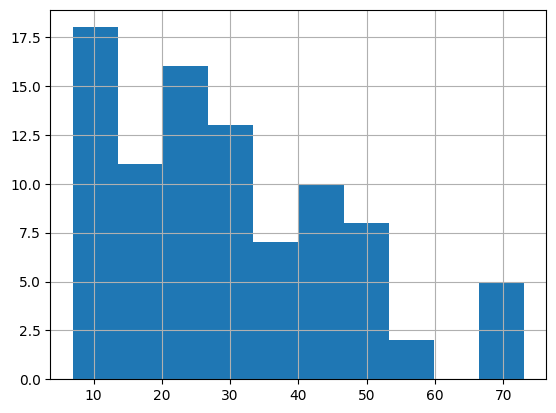

In [64]:
(runs_to_predict["frame_end_run"] - runs_to_predict["frame_start_run"]).hist()

# Build Graph

In [65]:
RUN_NUM = 0
RUN_FRAME = 2
run = runs_to_predict.iloc[RUN_NUM]
match_id = run["match_id"]
run_id = run["id"]
player = run["player_id"]

run_tracking = tracking_data[(tracking_data.run_id == run_id) & (tracking_data.match_id == match_id)]
run_tracking["timestamp"] = pd.to_timedelta(run_tracking["timestamp"]).dt.total_seconds()
frame_num = run_tracking["frame_id"].sort_values().iloc[0] + RUN_FRAME
frame_df = run_tracking[run_tracking["frame_id"]==frame_num]


graph = build_graph_from_frame(frame_df=frame_df,runner_player_id=player,player_to_team=player_to_team)
graph

C:\Users\zcoch\AppData\Local\Temp\ipykernel_33352\2430058148.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  run_tracking["timestamp"] = pd.to_timedelta(run_tracking["timestamp"]).dt.total_seconds()


Data(x=[23, 10], edge_index=[2, 506], edge_attr=[506, 4], runner_idx=21, team_ids=[23], is_ball=[23])

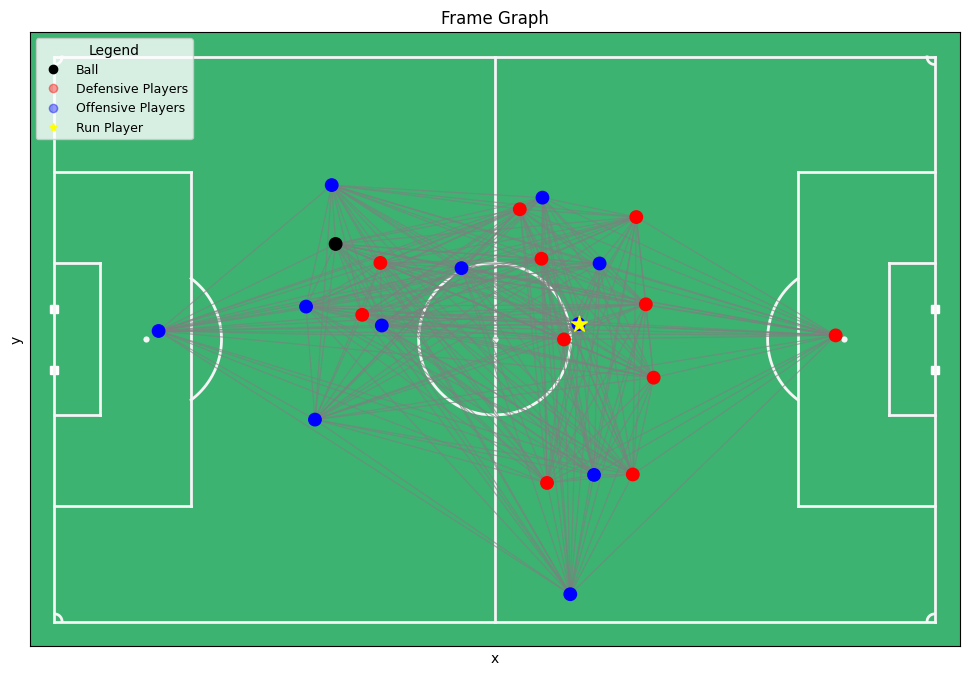

In [66]:
%matplotlib inline
plot_spatial_graph(graph)

# Temporal Dataset class

In [67]:
dataset = TemporalRunnerDataset(
    tracking_df=tracking_frame_groups,
    run_features=runs_to_predict,
    player_to_team=player_to_team,
)
dataset

In [68]:
dataset[3]

([Data(x=[23, 10], edge_index=[2, 506], edge_attr=[506, 4], runner_idx=21, team_ids=[23], is_ball=[23]),
  Data(x=[23, 10], edge_index=[2, 506], edge_attr=[506, 4], runner_idx=21, team_ids=[23], is_ball=[23]),
  Data(x=[23, 10], edge_index=[2, 506], edge_attr=[506, 4], runner_idx=21, team_ids=[23], is_ball=[23]),
  Data(x=[23, 10], edge_index=[2, 506], edge_attr=[506, 4], runner_idx=21, team_ids=[23], is_ball=[23]),
  Data(x=[23, 10], edge_index=[2, 506], edge_attr=[506, 4], runner_idx=21, team_ids=[23], is_ball=[23]),
  Data(x=[23, 10], edge_index=[2, 506], edge_attr=[506, 4], runner_idx=21, team_ids=[23], is_ball=[23]),
  Data(x=[23, 10], edge_index=[2, 506], edge_attr=[506, 4], runner_idx=21, team_ids=[23], is_ball=[23]),
  Data(x=[23, 10], edge_index=[2, 506], edge_attr=[506, 4], runner_idx=21, team_ids=[23], is_ball=[23]),
  Data(x=[23, 10], edge_index=[2, 506], edge_attr=[506, 4], runner_idx=21, team_ids=[23], is_ball=[23]),
  Data(x=[23, 10], edge_index=[2, 506], edge_attr=[506,

# Temporal GNN

# Training Loop

In [69]:
from torch.utils.data import DataLoader
dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

node_feat_dim = 10
gnn_hidden_dim = 64   
rnn_hidden_dim = 128 

model = TemporalRunnerGNN(node_feat_dim, gnn_hidden_dim, rnn_hidden_dim).to(device)

model = train_model(model,device = device, dataloader=dataloader,num_epochs=1)


100%|██████████| 23/23 [00:12<00:00,  1.91it/s]

Epoch 1, Loss: 68.29670466547427


# Load Model From Saved State

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TemporalRunnerGNN(10, 64, 128)
model.load_state_dict(torch.load("temporal_runner_gnn_final.pth"))
model.to(device)
model.eval() 

TemporalRunnerGNN(
  (gnn1): GCNConv(10, 64)
  (gnn2): GCNConv(64, 64)
  (rnn): GRU(64, 128, batch_first=True)
  (pos_head): Linear(in_features=128, out_features=2, bias=True)
)

# Given tracking data and runner id predict optimal run path

In [71]:
model.eval()
T = 10
RUN_NUM = 26
run = runs_to_predict.iloc[RUN_NUM]
match_id = run['match_id']
run_id = run['event_id']
runner_id = run['player_id']
team_id = run["team_id"]

absolute_path = predict_optimal_run(run,model,tracking_frame_groups=tracking_frame_groups,device = device,player_to_team = player_to_team)

# Plot Optimal Run Path

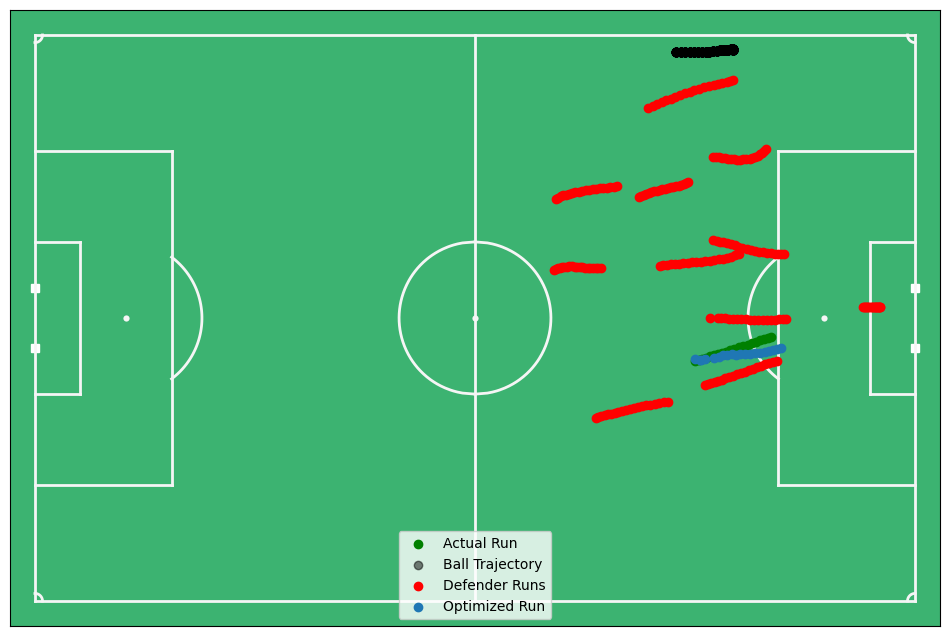

In [72]:
%matplotlib inline
plot_optimal_run(run,tracking_frame_groups=tracking_frame_groups,player_to_team=player_to_team,absolute_path=absolute_path)

# Animate Optimal Run

In [73]:
# Transform for animation
run_tracking = tracking_frame_groups[(match_id, run_id)].sort_values('frame_id')
pred_x = pd.Series(absolute_path[:,0])
pred_y = pd.Series(absolute_path[:,1])
dx = pred_x - pred_x.shift(1)
dy = pred_y - pred_y.shift(1)
s = np.sqrt(dx**2 + dy**2) * 10
d = np.arctan2(dy,dx)
pred_vals = pd.concat([pred_x,pred_y,dx,dy,s,d],axis=1)
pred_vals.columns = ["x","y","dx","dy","s","d"]
pred_vals["player"] = -1
pred_run = run_tracking[(run_tracking.run_active) & (run_tracking.player==runner_id)].copy()
pred_run.loc[:,["x","y","dx","dy","s","d","player"]] = pred_vals.fillna(0).values

In [74]:
%matplotlib tk

run_tracking_with_pred = pd.concat([run_tracking,pred_run])
animate_run(run=run,tracking_data=run_tracking_with_pred,player_to_team=player_to_team)

# View run examples
run #26 for positioning between players